In [36]:
import os
from PIL import Image
from torchvision import models, transforms
import torch
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
import timm
import random


# Ensure the script is being run on a machine with a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet model
model = timm.create_model('inception_v3', pretrained=True, num_classes=4).to(device)
model.load_state_dict(torch.load("/home/flix/Documents/DeepFlix/generative/diffusion/evaluation/models/finetuned_best.pt"))
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device)
model.eval()

# Remove the last layer (classification layer)
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Transformation to apply on the images
transform = transforms.Compose([
    transforms.Resize((496, 496)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

num_images_per_class = 500

classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

feature_dict = {}
image_paths = {}

for class_ in classes:

    # Folder containing images
    folder_path = f"/home/flix/Documents/oct-data/CellData/OCT_resized/train/{class_}"

    # List to store features
    features = []

    list_dir = os.listdir(folder_path)


    # shuffle the list_dir
    random.shuffle(list_dir)
    image_paths[class_] = list()
    # Extract features from each image
    for filename in tqdm(list_dir[:num_images_per_class]):
        
        if filename.endswith('.jpeg'):  # Add more conditions for other image types if needed
            img_path = os.path.join(folder_path, filename)
            image_paths[class_].append(img_path)
            img = Image.open(img_path).convert('RGB')
            img = transform(img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                feature = model(img)
            
            # reshape and append features
            features.append(feature.cpu().numpy().reshape(-1))

    # Convert list of features to numpy array
    features = np.array(features)

    # Store the features in a dictionary
    feature_dict[class_] = features

100%|██████████| 500/500 [00:18<00:00, 27.60it/s]


In [60]:
from sklearn.decomposition import PCA
from scipy.spatial import distance

# First, we'll concatenate all the features and keep track of their corresponding labels and paths
all_features = []
all_labels = []
all_paths = []
for class_, features in feature_dict.items():
    all_features.extend(features)
    all_labels.extend([class_] * len(features))
    all_paths.extend(image_paths[class_])

all_features = np.array(all_features)
all_labels = np.array(all_labels)

# Now we can perform PCA
pca = PCA(n_components=100)
reduced_features = pca.fit_transform(all_features)

# print cummulative explained variance
print(np.sum(pca.explained_variance_ratio_))

# Compute the center of each class
centers = {class_: np.mean(reduced_features[all_labels == class_], axis=0) for class_ in classes}

# Compute the distance from each point in CNV, DME, and DRUSEN to the center of NORMAL
distances = {}
for class_ in ['CNV', 'DME', 'DRUSEN', 'NORMAL']:
    distances[class_] = distance.cdist(reduced_features[all_labels == class_], centers['NORMAL'].reshape(1, -1), 'euclidean')

0.97920597


CNV
8.457391522782254
DME
9.230202038394186
DRUSEN
8.387243199064796
NORMAL
2.764178420852127


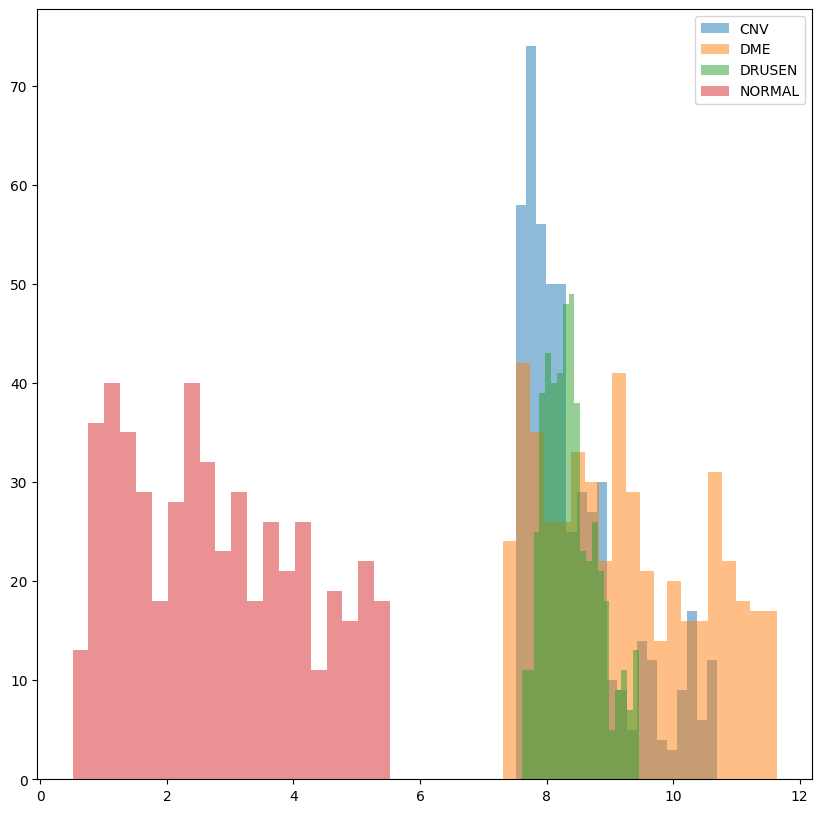

In [37]:
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt

# First, we'll concatenate all the features and keep track of their corresponding labels and paths
all_features = []
all_labels = []
all_paths = []
for class_, features in feature_dict.items():
    all_features.extend(features)
    all_labels.extend([class_] * len(features))
    all_paths.extend(image_paths[class_])

all_features = np.array(all_features)
all_labels = np.array(all_labels)

reduced_feature_dict = {}

# Create a UMAP object
umap = UMAP(n_components=25, random_state=42, n_neighbors=25, min_dist=0.1)

# Loop through each class
for class_ in classes:
    # Reduce the dimension of features using UMAP
    reduced_features = umap.fit_transform(feature_dict[class_])
    reduced_feature_dict[class_] = reduced_features


from scipy.spatial import distance

# Compute the center of each class
centers = {class_: np.mean(reduced_feature_dict[class_], axis=0) for class_ in classes}

# Compute the distance from each point in CNV, DME, and DRUSEN to the center of NORMAL
distances = {}
for class_ in ['CNV', 'DME', 'DRUSEN', 'NORMAL']:
    distances[class_] = distance.cdist(reduced_feature_dict[class_], centers['NORMAL'].reshape(1, -1), 'euclidean')

for c in classes:
    print(c)
    print(np.mean(distances[c]))

# Plot the distances
plt.figure(figsize=(10, 10))
for class_ in classes:
    plt.hist(distances[class_], label=class_, alpha=0.5, bins=20)
plt.legend()
plt.show()

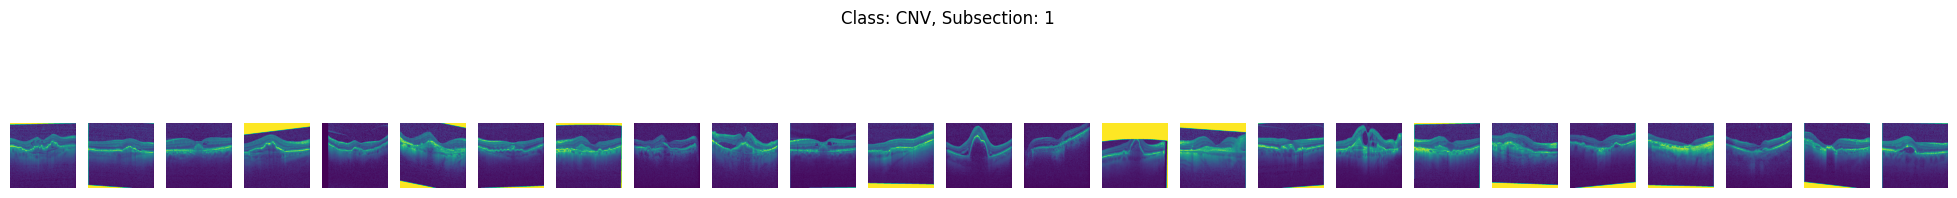

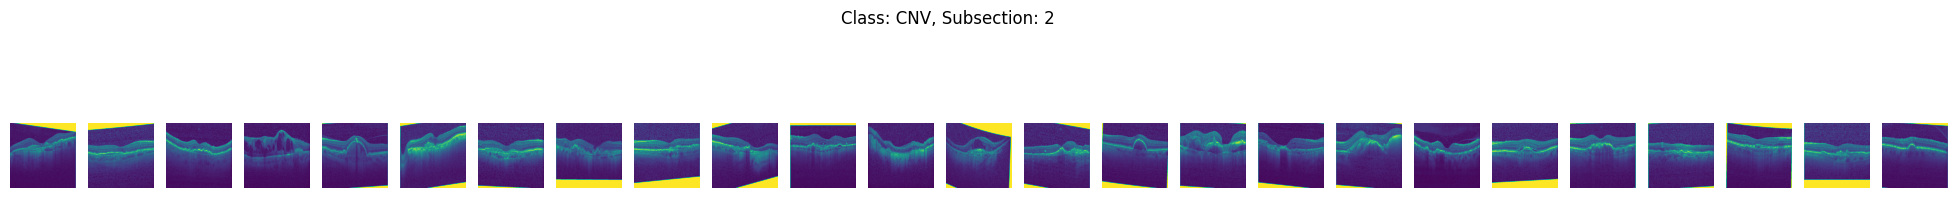

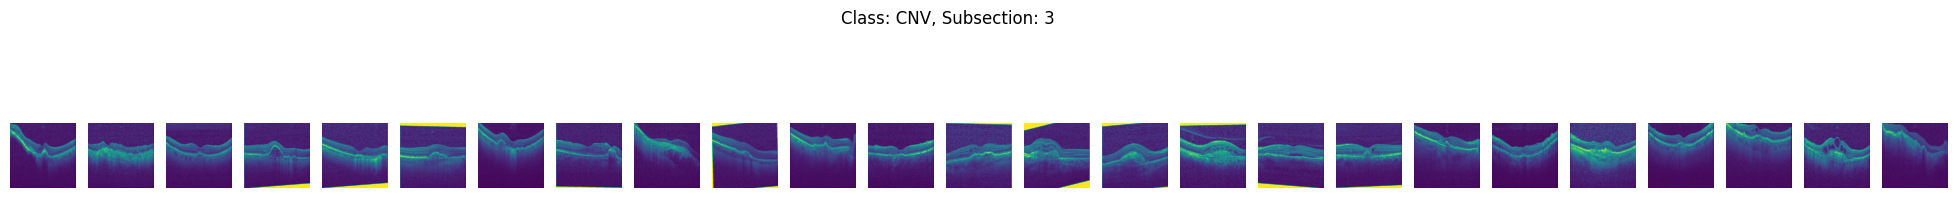

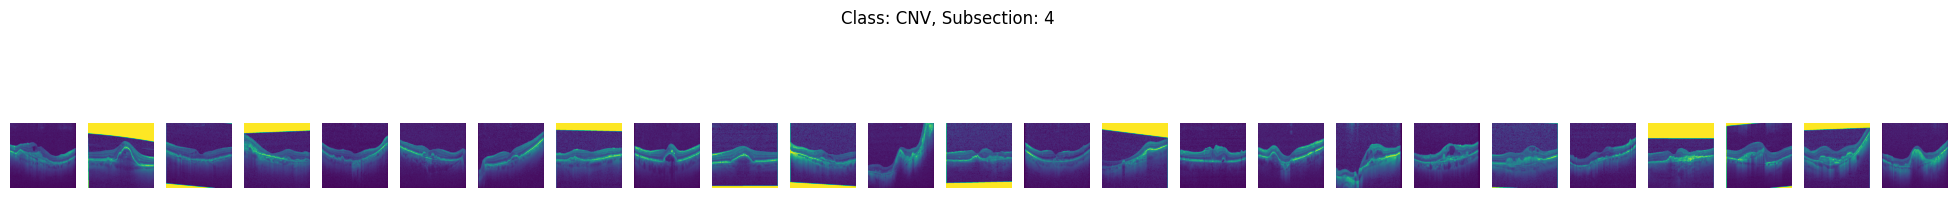

In [38]:
N = 4 # number of subsections

# Create dictionaries to hold the subsections
distance_subsections = {}
path_subsections = {}

# Let's focus on 'CNV' class as per your example
class_ = 'CNV'
class_distances = distances[class_]

# Get the indices that would sort the distances
sorted_indices = np.argsort(class_distances, axis=None)

# Sort the distances and paths using these indices
sorted_distances = class_distances[sorted_indices]
sorted_paths = np.array(image_paths[class_])[sorted_indices]

distance_subsections[class_] = np.array_split(sorted_distances, N)
path_subsections[class_] = np.array_split(sorted_paths, N)


import matplotlib.pyplot as plt

# For each subsection in 'path_subsections', open and plot 5 images
for class_, subsection_paths in path_subsections.items():
    for i, paths in enumerate(subsection_paths):
        # We will plot at most 5 images per subsection
        num_images = min(25, len(paths))
        
        fig, axs = plt.subplots(1, num_images, figsize=(25, 3))
        fig.suptitle(f'Class: {class_}, Subsection: {i + 1}')
        
        for j in range(num_images):
            img = Image.open(paths[j])
            axs[j].imshow(img)
            axs[j].axis('off')
        
        plt.show()

In [28]:
print(distance_subsections["DME"])

[array([[8.43095094],
       [8.43300406],
       [8.43902795],
       [8.49723471],
       [8.505787  ],
       [8.53539765],
       [8.5604566 ],
       [8.58609878],
       [8.59174388],
       [8.59340678],
       [8.60111511],
       [8.60371338],
       [8.60635843],
       [8.60916604],
       [8.61787924],
       [8.62256395],
       [8.63399809],
       [8.63598345],
       [8.64164432],
       [8.64634633],
       [8.65355186],
       [8.66185774],
       [8.66778935],
       [8.67095563],
       [8.67408172],
       [8.67508889],
       [8.67523365],
       [8.67911646],
       [8.6841361 ],
       [8.68704582],
       [8.71201162],
       [8.72645883],
       [8.73223605],
       [8.73460314],
       [8.76998939],
       [8.78376009],
       [8.79108211],
       [8.79667979],
       [8.80381731],
       [8.81367243],
       [8.81708719],
       [8.81837158],
       [8.81942645],
       [8.82454616],
       [8.83557935],
       [8.83937409],
       [8.84258117],
       [8.84